In [1]:
import ROOT as r
import math
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
r.gStyle.SetOptStat(0)
r.gStyle.SetOptFit(1111)

Welcome to JupyROOT 6.12/06


This file contains the timeing corrected data from the 60hour data set in a TH3. The x:y:z axes of the TH3 are time(mu s):energy(MeV):CalorimeterNumber

In [2]:
f = r.TFile("./newPileupHists_gm2offline_ana_60h_pileup_corrected_only.root")
f.cd()
f.ls()

TFile**		./newPileupHists_gm2offline_ana_60h_pileup_corrected_only.root	
 TFile*		./newPileupHists_gm2offline_ana_60h_pileup_corrected_only.root	
  KEY: TH3D	corrected;1	corrected


We can see this if we plot the projections of this onto the three axes

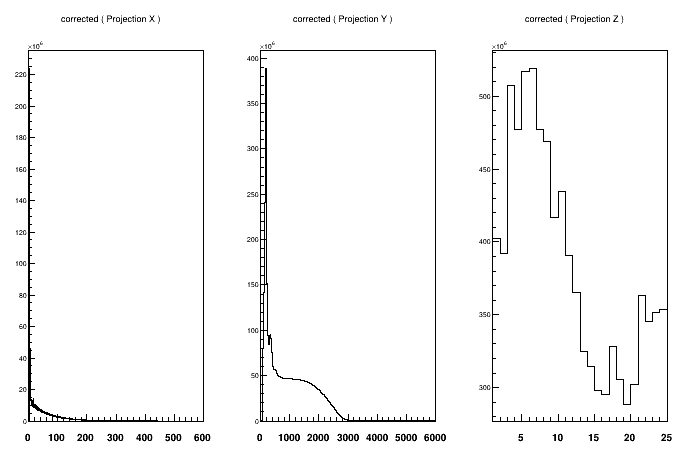

In [3]:
c = r.TCanvas()
c.Divide(3,1)
c.cd(1)
f.corrected.ProjectionX().Draw() #time (us)
c.cd(2)
f.corrected.ProjectionY().Draw() #energy (MeV)
c.cd(3)
f.corrected.ProjectionZ().Draw() # calonum
c.Draw()

We can now get the wiggle plot. The red curve shows the plot when an energy cut has been implemented. The black is all of the raw data.

101 201


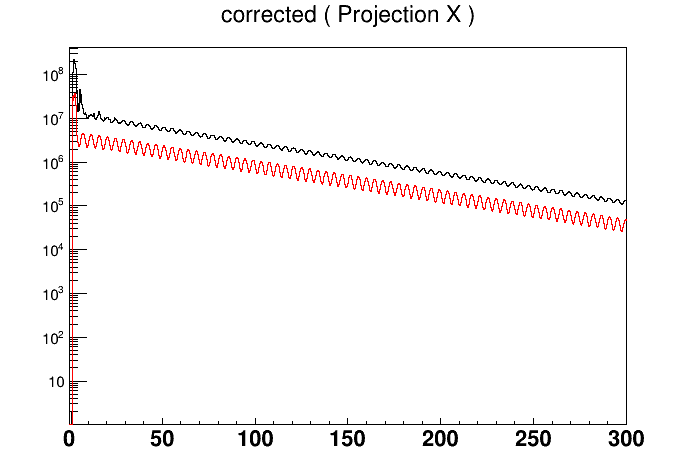

In [4]:
c2 = r.TCanvas()
c2.SetLogy()
h = f.corrected.ProjectionX()
h.GetXaxis().SetRangeUser(0,300)
h.Draw()

#get max an min bins for energy cut. Want the bounds to be > 1300 and < 3000 to match last analysis
# could probably get away with > 1000

energyhist = f.corrected.ProjectionY()
minenergybin = energyhist.FindBin(1500) #try switching from 1000 -> 1500 
maxenergybin = energyhist.FindBin(3000)
print(minenergybin,maxenergybin)

h2 = f.corrected.ProjectionX("px_cut",minenergybin,maxenergybin,0,-1,"")
h2.SetLineColor(2)
h2.Draw("SAME")

c2.Draw()

Now we can work towards fitting this using the blinding algorithm

In [5]:
# blinded instance
getBlinded = Blinders(FitType.Omega_a, 'This is my fight song. Blinding my plot song.')
def blinded_wiggle(x, p):
    norm  = p[0]
    life  = p[1]
    asym  = p[2]
    R     = p[3]
    phi   = p[4]
    
    time  = x[0]
    omega = getBlinded.paramToFreq(R)
#    omega = myBlinder.paramToFreq(R) unblind version
    
    return norm * math.exp(-time/life) * (1 - asym*math.cos(omega*time + phi))

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


 FCN=7859.81 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS        1210 TOTAL
                     EDM=1.14853e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  N            3.92578e+06   2.02570e+02   1.10592e-01   4.05109e-11
   2  #tau         6.44063e+01   1.91858e-03  -5.71915e-07  -2.24945e-05
   3  A           -3.32386e-01   3.79855e-05  -5.54096e-09  -9.12723e-06
   4  R           -1.53737e+01   1.34160e+00  -1.37463e-04  -1.07653e-07
   5  #phi        -1.11006e+02   2.14613e-04   2.14613e-04   7.30553e-04


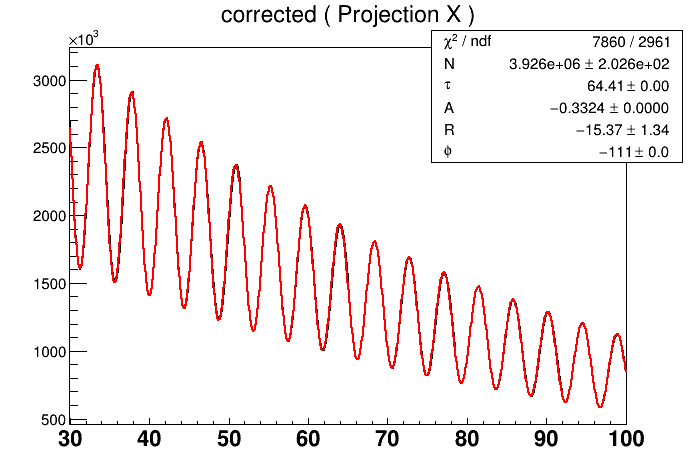

In [6]:
ding = "full_fit"
func = r.TF1(ding, blinded_wiggle, 30,400,5)
func.SetParNames('N','#tau','A','R','#phi')
func.SetParameters(1500,64.4,0.4,-15,0)
func.SetLineColor(2)
func.SetNpx(1000)
r.gStyle.SetOptFit(111)

c = r.TCanvas()
h2.SetLineColor(1)
h2.Draw()
h2.GetXaxis().SetRangeUser(30,500)
h2.Fit(ding,'REM')
func.Draw("SAME")

h2.GetXaxis().SetRangeUser(30,100)

c.Draw()

We can see that this fits the plot quite well. Now calculating the residuals:

Warning in <TFile::Append>: Replacing existing TH1: Graph (Potential memory leak).


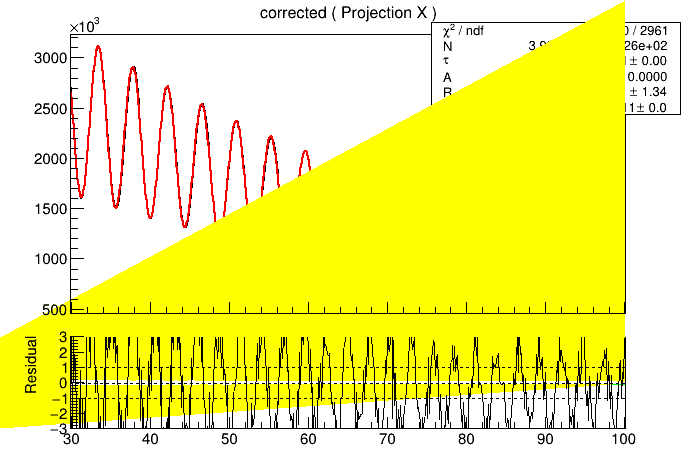

In [7]:
#The class calculates the  difference between the histogram and the fit function at each point 
#    and divides it by the uncertainty.
c2 = r.TCanvas()
rp1 = r.TRatioPlot(h2)
rp1.Draw()
rp1.GetLowerRefYaxis().SetTitle("Residual")
rp1.GetLowerRefYaxis().SetRangeUser(-3,3)
tgraph = rp1.GetCalculationOutputGraph()
dong = r.TGraphAsymmErrors(tgraph)
dong.SetTitle("asym")
c2.Draw()

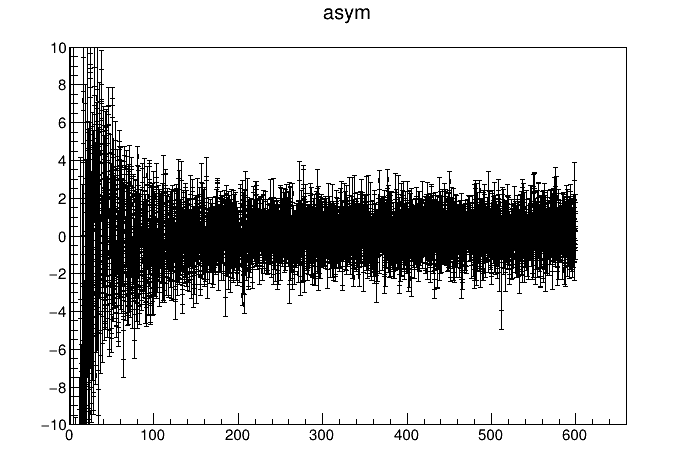

In [8]:
c3 = r.TCanvas()
dong.Draw("a p0 l")
dong.GetYaxis().SetRangeUser(-10,10)
c3.Draw()

Lets see what frequency components are lurking in there, using pythons FFT algorithm. We exclude the first 3 $\mu$s becuase they have no data and thus have crazy residuals

In [9]:
ratiolist = []
ratiolist.append(dong)
namelist = ['full']

Number of bins: 4765 ; Total Time range: 590.0228642693827
Center of min/max bin: 9.665350239035543  /  599.6882145084182
Width of each bin: 0.12382431569137098
Maximum Frequency / Sampling Rate (MHz): 8.075958218840272


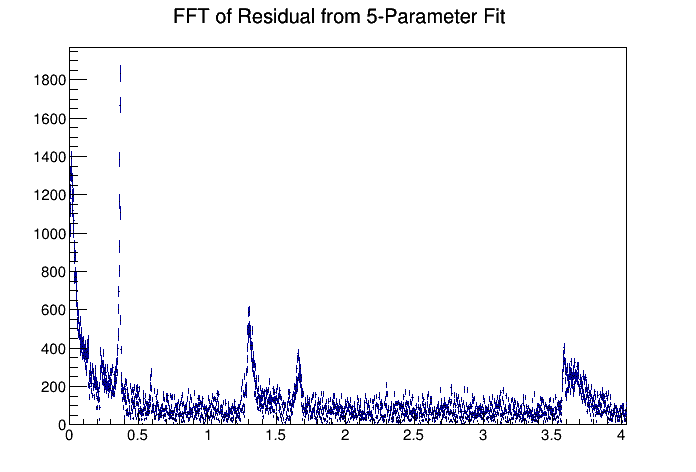

In [10]:
residxformlist = []
for j in range(0,len(namelist)):
    c3 = r.TCanvas()
    tgraph3 = ratiolist[j]
    c3.Draw()
    residualN = tgraph3.GetN() - 2
    listx = []
    listy = []
    minbin = 33 #cut out the first few microseconds where there is no data
    for i in range(minbin,residualN):
        xi = r.Double(9999)
        yi = r.Double(9999)
        tgraph3.GetPoint(i,xi,yi)
        listx.append(xi)
        listy.append(yi)
    #print(listx)
    
    import numpy
    window = numpy.bartlett(residualN)
    listywindow = []
    for i in range(minbin,residualN-minbin):
        listywindow.append(listy[i])
#        listywindow.append(listy[i]*window[i]) #add this back in to apply the window function
    fftyreal = numpy.real(numpy.fft.fft(listywindow))
    fftyim = numpy.imag(numpy.fft.fft(listywindow))
    ffty = []
    for i in range(0,len(fftyreal)):
        fftyi = numpy.sqrt(fftyreal[i]**2 + fftyim[i]**2)
        ffty.append(fftyi)
#    print(ffty)

    Npart = residualN - minbin
    minBinCenter = listx[minbin]
    maxBinCenter = listx[len(listx)-1]
    capT = maxBinCenter - minBinCenter
    print("Number of bins:", Npart, "; Total Time range:", capT)
    print("Center of min/max bin:", minBinCenter, " / ", maxBinCenter)
    deltaT = capT/Npart #microseconds
    deltaF = 1/capT
    print("Width of each bin:",deltaT)
#    print("Frequency of each bin:", deltaF)

    deltaTns = deltaT*1000 #nanoseconds
    limmaxHz = (1/(deltaTns*math.pow(10.0,-9))) #Hz
    limmaxMHz = limmaxHz / math.pow(10,6) #MHz

    print("Maximum Frequency / Sampling Rate (MHz):",limmaxMHz)

    hresid = r.TH1D("hresid","FFT of Residual from 5-Parameter Fit",residualN,0,residualN)
    for i in range(0,len(ffty)):
        hresid.SetBinContent(i,ffty[i])
    hresid.SetBins(residualN,0,limmaxMHz)
    hresid.GetXaxis().SetRangeUser(0,limmaxMHz/2)
    
    #hresid.Scale(1/(hresid.Integral()))
    
    hresid.Draw("HIST P0 L")
    
    c3.Draw()
    
    residxformlist.append(hresid.DrawClone(namelist[j]+"residxform"))

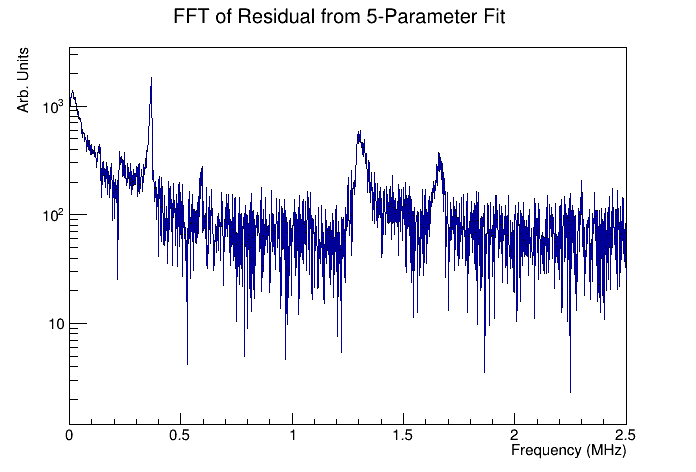

In [11]:
c4 = r.TCanvas()
c4.SetLogy()
hresid.Draw("P0 L")
hresid.GetXaxis().SetRangeUser(0,2.5)
hresid.GetXaxis().SetTitle("Frequency (MHz)")
hresid.GetYaxis().SetTitle("Arb. Units")
c4.Draw()

In [12]:
from matplotlib import pyplot as plt
plt.plot(listy[40:])
plt.plot(listywindow[40:])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

Lets fit these peaks

In [13]:
def peak_fit_bw(x, p):
    return p[0]*r.TMath.BreitWigner(x[0],p[1],p[2]) + p[3]

def peak_fit_simple(x, p):
    return p[0]*r.TMath.Exp(-0.5*((x[0]-p[1])/p[2])*((x[0]-p[1])/p[2])) + p[3]

func1 = r.TF1("peak1", peak_fit_simple, .36,.37,4)
func1.SetParNames('A','Mean','#gamma','+ C')
func1.SetParameters(.0001,.365,.1,0)
func1.SetParLimits(1,.36,.37)
func1.SetLineColor(2)
func1.SetNpx(1000)

func2 = r.TF1("peak2", peak_fit_simple, 1.2,1.4,4)
func2.SetParNames('A','Mean','#gamma','+ C')
func2.SetParameters(.3,1.37,-1)
func2.SetParLimits(1,1.2,1.4)

func3 = r.TF1("peak3", peak_fit_simple, 1.55,1.75,4)
func3.SetParNames('A','Mean','#gamma','+ C')
func3.SetParameters(.3,.37,-1)

Peak 1: 0.3651333739460702 MHz
Peak 2: 1.3143969892999448 MHz
Peak 3: 1.6565646890016574 MHz
 FCN=436.407 FROM MIGRAD    STATUS=FAILED         79 CALLS          80 TOTAL
                     EDM=3246.16    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  A            6.03263e+02   1.06824e-01   0.00000e+00  -6.84292e-04
   2  Mean         3.65133e-01   7.52100e-03   0.00000e+00  -8.97994e-01
   3  #gamma       1.17680e-01   2.09690e+01  -0.00000e+00   5.35774e+00
   4  + C          6.72111e+02   1.06781e-01   0.00000e+00  -1.61534e-04
 FCN=3116.43 FROM MINOS     STATUS=SUCCESSFUL     56 CALLS         747 TOTAL
                     EDM=8.46185e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  A          

Warning in <Fit>: Abnormal termination of minimization.
Warning in <Fit>: Abnormal termination of minimization.


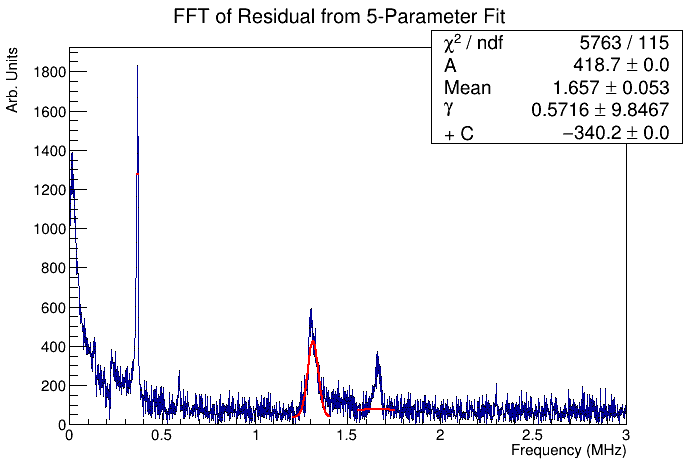

In [14]:
c5 = r.TCanvas()
hresid.Draw("P0 L")
hresid.GetXaxis().SetRangeUser(0,3)
hresid.GetXaxis().SetTitle("Frequency (MHz)")
hresid.GetYaxis().SetTitle("Arb. Units")
hresid.Fit("peak1","REMB")
hresid.Fit("peak2","REMB")
hresid.Fit("peak3","REMB")
func1.Draw("SAME")
func2.Draw("SAME")
func3.Draw("SAME")
hresid.GetXaxis().SetRangeUser(0,3)
c5.Draw()
print("Peak 1:",func1.GetParameter(1),"MHz")
print("Peak 2:",func2.GetParameter(1),"MHz")
print("Peak 3:",func3.GetParameter(1),"MHz")

This doesn't agree with the established frequencies... Lets use another method of FFT and see if we get a better result.

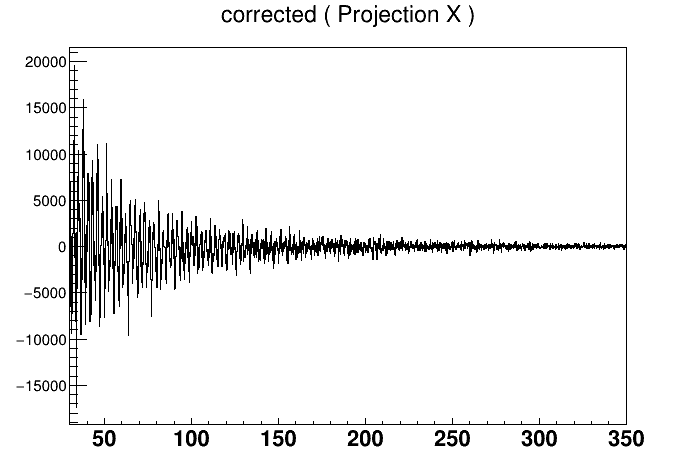

In [15]:
h5 = f.corrected.ProjectionX("px_cut",minenergybin,maxenergybin,0,-1,"")
c5 = r.TCanvas()
#c5.SetLogy()

for i in range(0,h2.GetNbinsX()-2):
    bincenter = h2.GetBinCenter(i)
    bincontent = h2.GetBinContent(i)
#    print(bincenter,bincontent)
    dong = bincontent - func.Eval(bincenter)
    h5.SetBinContent(i,dong)

h5.GetXaxis().SetRangeUser(30,350)
#h5.GetYaxis().SetRangeUser(-0.002,0.002)
    
h5.Draw()
#func.Draw("SAME")
c5.Draw()

4567
30.180835585117435  -  599.6258574101018
30.180835585117435


Warning in <TFile::Append>: Replacing existing TH1: h6 (Potential memory leak).


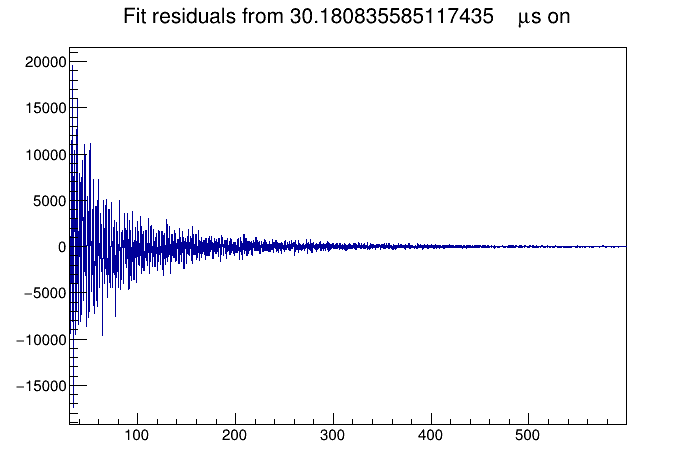

In [33]:
minbin = 242#33
maxbin = h5.GetNbinsX()-2

h6 = r.TH1D("h6","Fit residuals from 3 #mus on",int(h5.GetNbinsX()-2-minbin),0, 100)
for i in range(minbin,h5.GetNbinsX()-2):
    h6.SetBinContent(i-minbin,h5.GetBinContent(i))
    
print(h6.GetNbinsX())
    
h6min = h5.GetBinCenter(minbin) + h5.GetBinWidth(minbin)/2.0
h6max = h5.GetBinCenter(maxbin) - h5.GetBinWidth(maxbin)/2.0

h6.SetTitle("Fit residuals from "+str(h6min)+" #mus on")

print(h6min," - ", h6max)
h6.SetBins(h6.GetNbinsX(),h6min,h6max)

print(h6.GetBinCenter(0) + h6.GetBinWidth(0)/2.0)
    
c6 = r.TCanvas()
h6.Draw()
c6.Draw()

4567 569.4450218249845 30.118492140643493 599.563513965628
0.12468688894788361 0.0017560957804058986
16.040178858227478 8.020089429113737


Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).


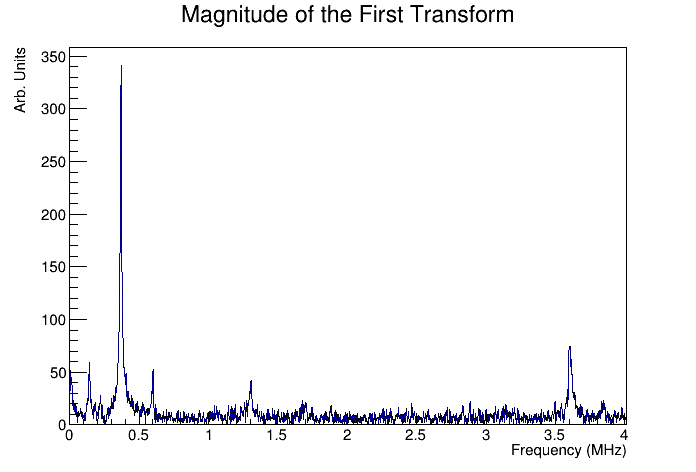

In [34]:
hxform = r.TH1D()
hxform = 0
r.TVirtualFFT.SetTransform(0)
h = h6
hxform = h.FFT(hxform,"MAG P")
hxform.SetTitle("Magnitude of the First Transform")
#NOTE: for "real" frequencies you have to divide the x-axes range with the range of your function
#    y-axes has to be rescaled by a factor of 1/SQRT(n) to be right: this is not done automatically!
normXform = hxform.GetEntries()
hxform.Scale(1/normXform)
#hxform.GetXaxis().SetRangeUser(0,limmax)
c2 = r.TCanvas()
c2.cd()
#c2.SetLogy()
hxform.GetXaxis().SetTitle("Frequency (MHz)")
hxform.GetYaxis().SetTitle("Arb. Units")
hxform.Draw("HIST P0 L")
c2.Draw()

Npart = h.GetSize() - 2
minBinCenter = h.GetXaxis().GetBinCenter(0)
maxBinCenter = h.GetXaxis().GetBinCenter(Npart)
#    minBinCenter = 0
#    maxBinCenter = 392.85
capT = maxBinCenter - minBinCenter
print(Npart, capT, minBinCenter, maxBinCenter)
deltaT = capT/Npart #microseconds
deltaF = 1/capT
print(deltaT, deltaF)

deltaTns = deltaT*1000 #nanoseconds
limmaxHz = (1/(deltaTns*math.pow(10.0,-9)))
limmaxMHz = limmaxHz / math.pow(10,6)

limmax = 2*deltaF*Npart #400-25
print(limmax,limmaxMHz)
#hxform.GetXaxis().SetLimits(0,limmax)
nbins = h.GetSize() - 2
hxform.SetBins(Npart,0,limmaxMHz)
hxform.GetXaxis().SetRangeUser(0,limmaxMHz/2)

c2.Draw()

In [41]:
func1 = r.TF1("peak1", peak_fit_bw, .33,.39,4)
func1.SetParNames('A','Mean','#gamma','+ C')
func1.SetParameters(.0001,.365,.1,0)
func1.SetParLimits(1,.37,.39)
func1.SetLineColor(2)
func1.SetNpx(1000)

func2 = r.TF1("peak2", peak_fit_bw, 1.2,1.4,4)
func2.SetParNames('A','Mean','#gamma','+ C')
func2.SetParameters(.3,1.37,-1)
func2.SetParLimits(1,1.2,1.4)

func3 = r.TF1("peak3", peak_fit_bw, 1.55,1.75,4)
func3.SetParNames('A','Mean','#gamma','+ C')
func3.SetParameters(.3,0.37,-1)

func4 = r.TF1("peak4", peak_fit_bw, 0.55,0.65,4)
func4.SetParNames('A','Mean','#gamma','+ C')
func4.SetParameters(.3,0.37,-1)

func5 = r.TF1("peak5", peak_fit_bw, 0.12,0.16,4)
func5.SetParNames('A','Mean','#gamma','+ C')
func5.SetParameters(.3,0.37,-1)

func6 = r.TF1("peak6", peak_fit_bw, 3.6,3.8,4)
func6.SetParNames('A','Mean','#gamma','+ C')
func6.SetParameters(.3,0.37,-1)

func7 = r.TF1("peak7", peak_fit_bw, 3.8,3.9,4)
func7.SetParNames('A','Mean','#gamma','+ C')
func7.SetParameters(.3,0.37,-1)

Peaks Located at: 
     0.14322330831382518 MHz
     0.3704419182399096 MHz
     0.5966615091579575 MHz
     1.3029834905877493 MHz
     1.6870128553938455 MHz
     3.6003064583913065 MHz
     3.8396431721328104 MHz
 FCN=135178 FROM MINOS     STATUS=SUCCESSFUL     32 CALLS         210 TOTAL
                     EDM=1.59246e-14    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  A            6.02456e+00   3.51287e-03   5.54133e-07  -1.31259e-02
   2  Mean         3.70442e-01   2.66507e-06  -1.34078e-07   2.13530e-02
   3  #gamma       1.33080e-02   1.02570e-05   2.27427e-09  -4.82492e+00
   4  + C          2.52297e+01   3.68935e-02   3.68935e-02  -3.22621e-04
 FCN=1.09579e+06 FROM MINOS     STATUS=SUCCESSFUL     32 CALLS         206 TOTAL
                     EDM=1.97594e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                

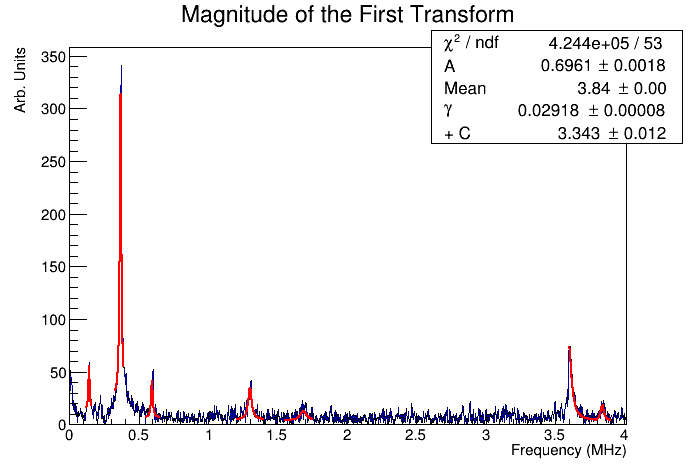

In [46]:
c = r.TCanvas()
hxform.GetXaxis().SetRangeUser(0,limmaxMHz/2)
hxform.Draw("HIST P0 L")

hxform.Fit("peak1","REMB")
hxform.Fit("peak2","REMB")
hxform.Fit("peak3","REMB")
hxform.Fit("peak4","REMB")
hxform.Fit("peak5","REMB")
hxform.Fit("peak6","REMB")
hxform.Fit("peak7","REMB")

func1.Draw("SAME")
func2.Draw("SAME")
func3.Draw("SAME")
func4.Draw("SAME")
func5.Draw("SAME")
func6.Draw("SAME")
func7.Draw("SAME")

print("Peaks Located at: ")
print("    ",func5.GetParameter(1),"MHz")
print("    ",func1.GetParameter(1),"MHz")
print("    ",func4.GetParameter(1),"MHz")
print("    ",func2.GetParameter(1),"MHz")
print("    ",func3.GetParameter(1),"MHz")
print("    ",func6.GetParameter(1),"MHz")
print("    ",func7.GetParameter(1),"MHz")

#hxform.GetXaxis().SetRangeUser(0,0.5)

c.Draw()

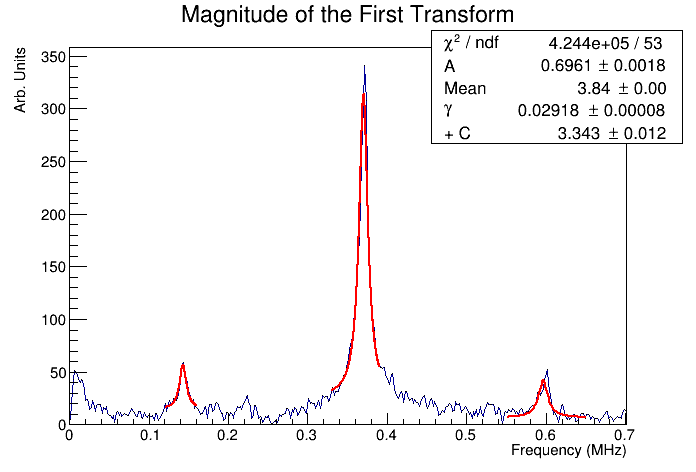

In [47]:
hxform.GetXaxis().SetRangeUser(0,0.7)
c.Draw()

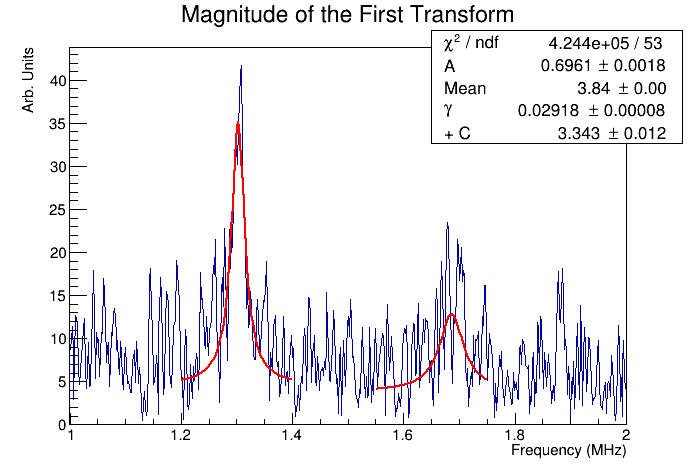

In [48]:
hxform.GetXaxis().SetRangeUser(1,2)
c.Draw()

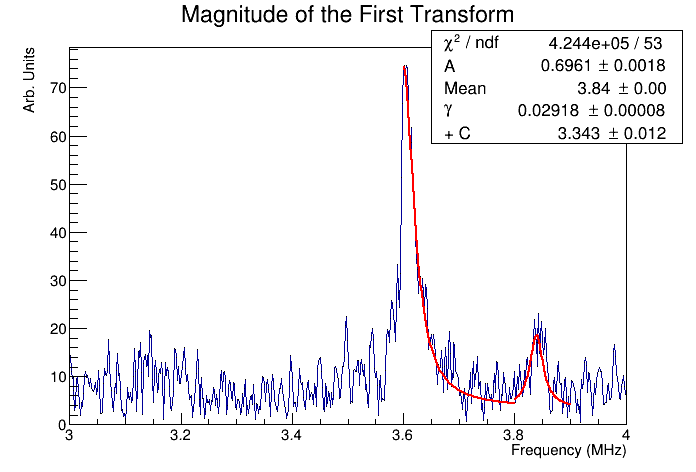

In [49]:
hxform.GetXaxis().SetRangeUser(3,4)
c.Draw()